<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/DR-stage-identification/DR_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from tensorflow.keras import layers, models
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Feature Extraction

In [ ]:
# Dataset Paths
DATASET_DIR = "/content/drive/MyDrive/DR_StageIdentification Classification_Model/Dataset"
TRAIN_CSV = os.path.join(DATASET_DIR, "train.csv")
VAL_CSV = os.path.join(DATASET_DIR, "validation.csv")
TEST_CSV = os.path.join(DATASET_DIR, "test.csv")

TRAIN_DIR = os.path.join(DATASET_DIR, "Train_Images")
VAL_DIR = os.path.join(DATASET_DIR, "Validation_Images")
TEST_DIR = os.path.join(DATASET_DIR, "Test_Images")

# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure images have ".png" extension
train_df['id_code'] = train_df['id_code'].astype(str) + ".png"
val_df['id_code'] = val_df['id_code'].astype(str) + ".png"
test_df['id_code'] = test_df['id_code'].astype(str) + ".png"

# Diagnosis Mapping
diagnosis_mapping = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR",
}

train_df['diagnosis'] = train_df['diagnosis'].astype(int).map(diagnosis_mapping)
val_df['diagnosis'] = val_df['diagnosis'].astype(int).map(diagnosis_mapping)
test_df['diagnosis'] = test_df['diagnosis'].astype(int).map(diagnosis_mapping)

# Image Preprocessing
IMG_SIZE = (224, 224)  # ResNet50 and MobileNetV2 require 224x224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col="id_code",
    y_col="diagnosis",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data Generators Initialized.")

# Load ResNet50 and MobileNetV2 for Feature Extraction
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Convert to feature extractors
resnet_base.trainable = False
mobilenet_base.trainable = False

# Function to extract features
def extract_features(model, generator, num_samples):
    """Extracts features using a given model."""
    steps = int(np.ceil(num_samples / BATCH_SIZE))
    features = model.predict(generator, steps=steps, verbose=1)
    return features

# Extract Features
print("Extracting Features using ResNet50...")
train_features_resnet = extract_features(resnet_base, train_generator, int(len(train_df)))
val_features_resnet = extract_features(resnet_base, val_generator, int(len(val_df)))
test_features_resnet = extract_features(resnet_base, test_generator, int(len(test_df)))

print("Extracting Features using MobileNetV2...")
train_features_mobilenet = extract_features(mobilenet_base, train_generator, int(len(train_df)))
val_features_mobilenet = extract_features(mobilenet_base, val_generator, int(len(val_df)))
test_features_mobilenet = extract_features(mobilenet_base, test_generator, int(len(test_df)))

# Save extracted features
np.save("train_features_resnet.npy", train_features_resnet)
np.save("val_features_resnet.npy", val_features_resnet)
np.save("test_features_resnet.npy", test_features_resnet)

np.save("train_features_mobilenet.npy", train_features_mobilenet)
np.save("val_features_mobilenet.npy", val_features_mobilenet)
np.save("test_features_mobilenet.npy", test_features_mobilenet)

# Save labels
train_labels = to_categorical(train_generator.classes, num_classes=5)
val_labels = to_categorical(val_generator.classes, num_classes=5)
test_labels = to_categorical(test_generator.classes, num_classes=5)

np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)
np.save("test_labels.npy", test_labels)

print("Feature Extraction Complete.")

Found 3528 validated image filenames belonging to 5 classes.
Found 757 validated image filenames belonging to 5 classes.
Found 756 validated image filenames belonging to 5 classes.
Data Generators Initialized.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting Features using ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/111 ━━━━━━━━━━━━━━━━━━━━ 812s 7s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step
Extracting Features using MobileNetV2...
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step
Feature Extraction Complete.


### Model Building

In [ ]:
# Load extracted features
train_features_resnet = np.load("train_features_resnet.npy")
val_features_resnet = np.load("val_features_resnet.npy")
test_features_resnet = np.load("test_features_resnet.npy")

train_features_mobilenet = np.load("train_features_mobilenet.npy")
val_features_mobilenet = np.load("val_features_mobilenet.npy")
test_features_mobilenet = np.load("test_features_mobilenet.npy")

# Load labels
train_labels = np.load("train_labels.npy")
val_labels = np.load("val_labels.npy")
test_labels = np.load("test_labels.npy")

# Concatenate features from both models
train_features = np.concatenate((train_features_resnet.reshape(len(train_features_resnet), -1),
                                 train_features_mobilenet.reshape(len(train_features_mobilenet), -1)), axis=1)

val_features = np.concatenate((val_features_resnet.reshape(len(val_features_resnet), -1),
                               val_features_mobilenet.reshape(len(val_features_mobilenet), -1)), axis=1)

test_features = np.concatenate((test_features_resnet.reshape(len(test_features_resnet), -1),
                                test_features_mobilenet.reshape(len(test_features_mobilenet), -1)), axis=1)

# Define Fully Connected Classifier
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(train_features.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels, epochs=50, validation_data=(val_features, val_labels))

# Save the trained classifier
model.save("diabetic_retinopathy_final_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.3463 - loss: 3.8455 - val_accuracy: 0.5509 - val_loss: 1.1201
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4434 - loss: 1.3481 - val_accuracy: 0.6407 - val_loss: 1.1500
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5301 - loss: 1.1895 - val_accuracy: 0.6473 - val_loss: 1.0120
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6053 - loss: 1.0389 - val_accuracy: 0.6843 - val_loss: 0.9052
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6516 - loss: 0.9432 - val_accuracy: 0.6684 - val_loss: 0.9388
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6703 - loss: 0.8935 - val_accuracy: 0.6513 - val_loss: 0.9355
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6973 - loss: 0.7915 - val_accuracy: 0.7067 - val_loss: 0.9094
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7288 - loss: 0.7472 - val_acc

### Model Evaluation

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step


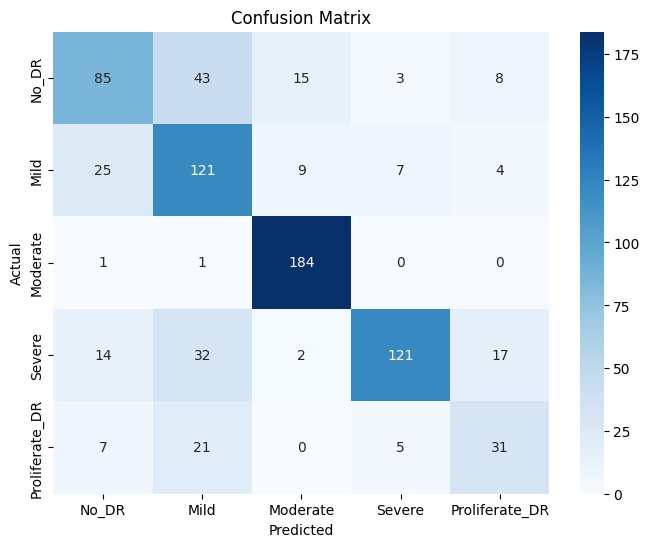

Classification Report:
                 precision    recall  f1-score   support

         No_DR       0.64      0.55      0.59       154
          Mild       0.56      0.73      0.63       166
      Moderate       0.88      0.99      0.93       186
        Severe       0.89      0.65      0.75       186
Proliferate_DR       0.52      0.48      0.50        64

      accuracy                           0.72       756
     macro avg       0.70      0.68      0.68       756
  weighted avg       0.73      0.72      0.72       756



In [ ]:
# Load the trained model
model = tf.keras.models.load_model("diabetic_retinopathy_final_model.h5")

# Load test data
# Load individual feature files and concatenate them
test_features_resnet = np.load("test_features_resnet.npy")
test_features_mobilenet = np.load("test_features_mobilenet.npy")
test_features = np.concatenate((test_features_resnet.reshape(len(test_features_resnet), -1),
                                test_features_mobilenet.reshape(len(test_features_mobilenet), -1)), axis=1)

test_labels = np.load("test_labels.npy") # This file was saved correctly

# Predict the test set
predictions = model.predict(test_features)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Define class labels
class_labels = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate and display Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", class_report)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

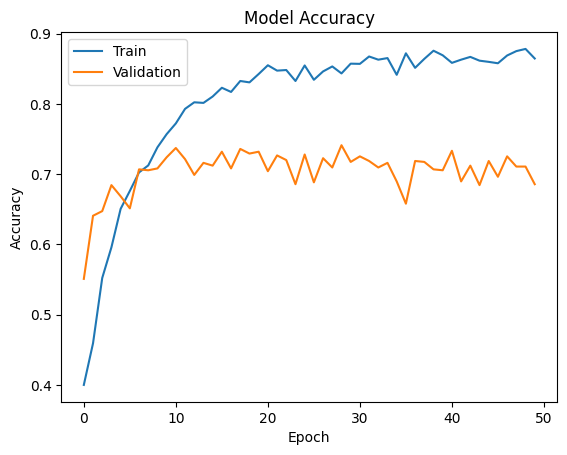

In [ ]:
# Test accuracy vs. Validation accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt